In [1]:
# Note: Don't import any other libraries for deep learning or ML in general.
import math
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# If you wish, you can include other libraries related to side tasks
# such as drawing images, showing a progress bar, etc.
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

## Define utility functions

In [111]:
# Note: If you wish to add or modify some utility functions, feel free to do so.

# You can change this variable to choose between discrete and continuous images
# In the discrete case, the image channels are of type uint8 with values from 0 to 255
# In the continous case, the image channels are of type float with values from 0 to 1
use_discrete_data = False

# Show a batch of images x and their corresponding classes y
# Params:
# - x: A tensor of shape [Batch Size, 1, Height, Width] and type float
# - y: A tensor of shape [Batch Size] and type int64
def show_images(x: torch.Tensor, y: torch.Tensor):
  # Convert images to a color uint8 numpy array
  #first unflatten the tensor
  x = x.view(x.shape[0], 1, 28, 28)
  if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
  else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
  # Calculate the number of rows and columns to organize the images
  count = x.shape[0]
  rows = max(1, int(count ** 0.5))
  columns = max(1, count // rows)
  # Draw a grid or images
  plt.figure(figsize=(columns, rows))
  for i in range(count):
    plt.subplot(rows, columns, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(f"Class: {y[i]}", fontsize=10)
  plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.show()

## Load and visualize the dataset

In [61]:
# TODO [Optional]: You can modify the transforms.
# Note: If you modify the transforms, you may need to modify the `show_images` function.
if use_discrete_data:
  transform = transforms.Compose([
      transforms.PILToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])
else:
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])

# This will load the dataset into the folder "datasets" the first time it is run
dataset = torchvision.datasets.MNIST(root="datasets", download=True, transform=transform)

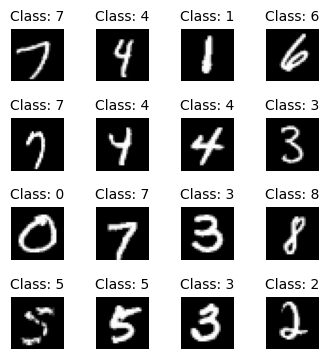

In [69]:
def show_dataset_sample(sample_size: int = 100):
  # sample_size must be a square number so the grid is all full
  loader = DataLoader(dataset, batch_size=sample_size, shuffle=True)
  x, y = next(iter(loader))
  x = x.view(sample_size, 1, 28, 28)
  y = y.view(sample_size)
  show_images(x, y)

show_dataset_sample(sample_size=16)

In [65]:
loader = DataLoader(dataset, batch_size=2, shuffle=True)
x, y = next(iter(loader))

In [66]:
x[0].shape, y.shape

(torch.Size([784]), torch.Size([2]))

In [68]:
x.view(2, 1, 28, 28).shape

torch.Size([2, 1, 28, 28])

In [7]:
# x.view(x[0].size(0), -1)

## Select a device

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected Device:", device)

Selected Device: cuda


## Define the model

In [9]:
# TODO: Define your model(s) and loss function(s) here.
# You can add as many cells as you like.
# You can add utility functions related to the model here too.

In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NADE(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        self.D = input_dim
        self.H = hidden_dim

        # Shared input-to-hidden weights (H x D)
        self.W = nn.Parameter(torch.randn(hidden_dim, input_dim) * 0.01)

        # Shared hidden bias (H)
        self.b = nn.Parameter(torch.zeros(hidden_dim))

        # Output weights per dimension (D x H)
        self.V = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01)

        # Output biases (D)
        self.c = nn.Parameter(torch.zeros(input_dim))

    def forward(self, x):
        """
        x: (batch, D), binary {0,1}
        Returns: log probability of each sample
        """
        batch_size = x.size(0)
        log_prob = torch.zeros(batch_size, device=x.device)

        # Running hidden pre-activation:
        # a_i = b + sum_{j < i} x_j * W[:, j]
        a = self.b.unsqueeze(0).expand(batch_size, -1)

        for i in range(self.D):
            # hidden for this dimension
            h = torch.sigmoid(a)   # (batch, H)

            # Output logit for p(x_i | x_<i)
            logits_i = (h @ self.V[i].unsqueeze(-1)).squeeze(-1) + self.c[i]
            p_i = torch.sigmoid(logits_i)

            # Accumulate log-likelihood
            log_prob += x[:, i] * torch.log(p_i + 1e-10) + \
                        (1 - x[:, i]) * torch.log(1 - p_i + 1e-10)

            # Update the pre-activation for next step
            # a_{i+1} = a + x_i * W[:, i]
            a = a + x[:, i].unsqueeze(1) * self.W[:, i].unsqueeze(0)

        return log_prob
    @torch.no_grad()
    def sample(self, batch_size, device= "cuda" if torch.cuda.is_available() else "cpu"):

        x_new = torch.zeros(batch_size, self.D, device=device)
        a = self.b.unsqueeze(0).expand(batch_size, -1)

        for pixel in range(self.D):
            h = torch.sigmoid(a)
            logits_i = (h @ self.V[pixel].unsqueeze(-1)).squeeze(-1) + self.c[pixel]
            p_i = torch.sigmoid(logits_i)
            x_i = torch.bernoulli(p_i)
            x_new[:, pixel] = x_i
            a = a + x_i.unsqueeze(1) * self.W[:, pixel].unsqueeze(0)
        return x_new
    def sample_continous(self, batch_size, device= "cuda" if torch.cuda.is_available() else "cpu"):

        x_new = torch.zeros(batch_size, self.D, device=device)
        a = self.b.unsqueeze(0).expand(batch_size, -1)

        for pixel in range(self.D):
            h = torch.sigmoid(a)
            # logits_i = (h @ self.V[pixel].unsqueeze(-1)).squeeze(-1) + self.c[pixel]
            # p_i = torch.sigmoid(logits_i)
            mu_i = (h @ self.V_mean[pixel].unsqueeze(-1)).squeeze(-1) + self.c_mean[pixel]
            logstd_i = (h @ self.V_logstd[pixel].unsqueeze(-1)).squeeze(-1) + self.c_logstd[pixel]
            std_i = torch.exp(logstd_i)
            x_i = torch.normal(mu_i, std_i)
            x[:, pixel] = x_i
            x_i = torch.clamp(x_i, 0.0, 1.0)

            # save
            x[:, pixel] = x_i
            a = a + x_i.unsqueeze(1) * self.W[:, pixel].unsqueeze(0)
        return x_new


## Define Hyperparameters

In [55]:
# TODO: Define the hyperparameters here.
input_dim = 28*28
hidden_dim = 16
epochs = 100
batch_size = 64
lr = 1e-3
max_patience = 20

## Instantiate models and optimizers

In [56]:
# TODO: Instantiate the models and optimizers here.
model = NADE(input_dim=input_dim, hidden_dim=hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)


## Train the model

In [13]:
# TODO: Write the code to train the model here

In [70]:
def train_nade(model, dataloader, epochs=20, lr=1e-3, device="cuda"):
    model = model.to(device)

    for epoch in range(epochs):
        total_loss = 0.0
        total_samples = 0

        for indx_batch, batch in enumerate(dataloader):
            # batch is a list of two x & y
            # x is torch.Size([batch_size, 1, 28, 28])
            # y is torch.Size([batch_size])
            x = batch[0]
            x = x.to(device).float()   # (batch, D)

            # Forward
            log_prob = model(x)       # (batch,)
            loss = -log_prob.mean()   # maximize log-likelihood

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

        avg_loss = total_loss / total_samples
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")


In [71]:

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
train_nade(model, train_loader, epochs=10, lr=1e-3)


Epoch 1/10 | Loss: 244.4148
Epoch 2/10 | Loss: 198.6911
Epoch 3/10 | Loss: 179.2230
Epoch 4/10 | Loss: 161.4506
Epoch 5/10 | Loss: 149.5781
Epoch 6/10 | Loss: 141.8044
Epoch 7/10 | Loss: 136.2876
Epoch 8/10 | Loss: 132.1561
Epoch 9/10 | Loss: 128.8974
Epoch 10/10 | Loss: 126.2493


## [Optional] Save and/or load the model

In [121]:
## Optional TODO: Save the model if you want to store your work on disk and load it later
# torch.save(model.state_dict(), "nade_mnist.pth")

model = NADE(input_dim=784, hidden_dim=16)
model.load_state_dict(torch.load("nade_mnist.pth"))
model.eval()

NADE()

## Write the generation function

In [122]:
# TODO: Rewrite the following function

# Given a tensor of classes y, this function conditionally generates a tensor images.
# Params:
# - y: A tensor of shape [Batch Size] and type int64 and resides on the CPU memory
# Return: A tensor of shape [Batch Size, 1, Height, Width] and type float32

def generate(y: torch.Tensor) -> torch.Tensor:
  batch_size = y.shape[0]
  model.eval()
  new_x = model.sample(batch_size=batch_size)
  return new_x

## Generate some images and display them

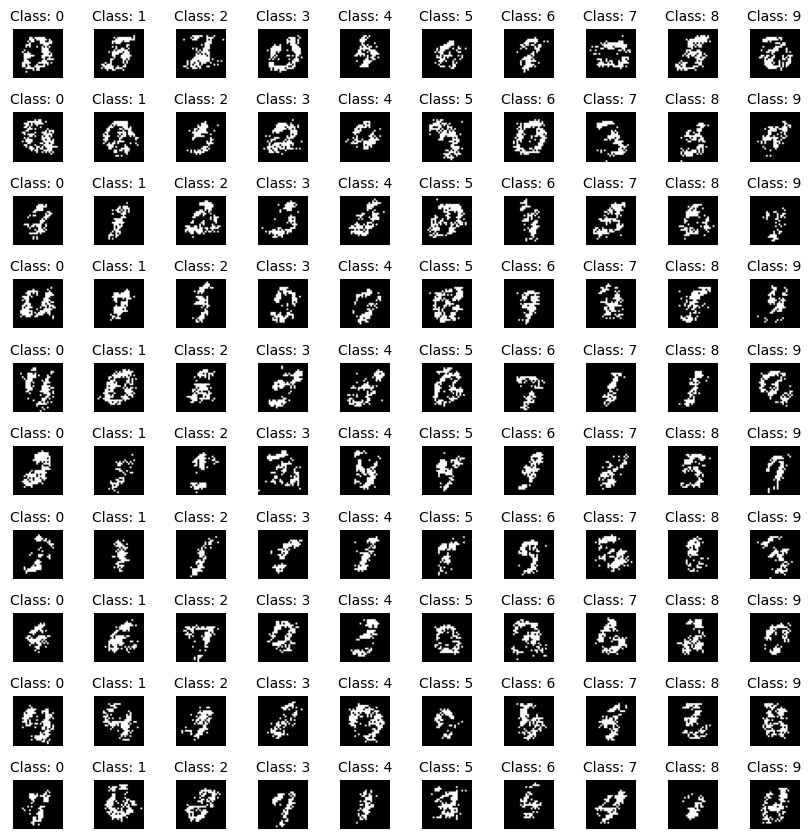

In [124]:
# Generate 100 images (10 images per class x 10 classes)
y = torch.tensor([i for _ in range(10) for i in range(10)], dtype=torch.long)
x = generate(y)
show_images(x, y)

## [Optional] Extras

You can do any extra stuff you want here. Some examples are:
* Draw a graph of the loss functions.
* Implement interpolation in latent space (You can try it with Normalizing flows, Latent variable models and Implicit models).
* Implement image in-painting (You can try it with Score-based models, and in a limited form with Autoregressive models too).
* Visualize the generation process (You can try it with Energy-based and Score-based models).